# Домашнее задание
Откуда берутся датасеты

Описание/Пошаговая инструкция выполнения домашнего задания: \\
По аналогии с занятием по парсингу данных, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).

Идеальный датасет должен иметь текстовое описание некоторого объекта и некоторую целевую переменную, соответствующую этому объекту. Например:

*  Сайт новостей: текстовое описание - сама новость, целевая переменная -
количество просмотров новости (можно поделить на число дней с момента даты публикации, чтобы получить “среднее число просмотров в день”). \\
*  Сайт с товарами/книгами/фильмами: текстовое описание товара/книги/фильма +
средний рейтинг в качестве целевой переменной.  \\
*  Блоги - тексты заметок + число просмотров. \\
*  И любые другие ваши идеи, которые подходят под такой формат.
Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.
Не забывайте, что парсинг - это ответственное мероприятие, поэтому не бомбардируйте несчастные сайты слишком частыми запросами (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла)
При необходимости очистить датасет от мусора с помощью регулярных выражений).
Посчитать статистики по собранным данным и провести EDA собранных данных (в случае, если данные представляют собой текст - посчитать частотности слов, выявить наиболее частотные слова и т. п)
Не забудьте сохранить полученный датасет, он вам еще пригодиться в дальнейших домашних заданиях.

In [ ]:
#!pip install fake_useragent

In [ ]:
import re
import pandas as pd
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

In [ ]:
# подгрузим один из методов этой библиотеки
from fake_useragent import UserAgent

In [ ]:
UserAgent().chrome

'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'

# Часть 1. Парсинг сайта

Парсинг сайта https://topliba.com/ с целью сбора данных о книгах (рейтинг, название, описание, год выпуска) по жанру Фэнтези. Дело в том, что большинство современных книжный сайтов не предоставляют возможности делать сквозной  поиск по всем страницам, а только в рамках жанровых категорий. Наиболее представленный жанр н данном сайте - фэнтези (783 страницы поиска) по нему и будем делать парсинг. На данном сайте список фильмов подгружается динамически по страницам. Обратимся к странице Фэнтези, и запишем запрос к данной странице.

In [ ]:
page_link = 'https://topliba.com/genres/12090?p=1'
# 'https://topliba.com/genres/12090?order_field=rating&p=1'

In [ ]:
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

In [ ]:
html = response.content

### Получение ссылок с книгами

С помощью библиотеки BeautifulSoup распарсим страницу и найдем ссылки книгам.

In [ ]:
soup = BeautifulSoup(response.content, 'html.parser')

In [ ]:
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
html = response.content
html[:1000]

b'<!DOCTYPE html>\n<html lang="ru">\n    <head>\n        <meta charset="utf-8">\n        <meta http-equiv="X-UA-Compatible" content="IE=edge">\n        <meta name="viewport" content="width=device-width, initial-scale=1">\n        <title>\xd0\xa4\xd1\x8d\xd0\xbd\xd1\x82\xd0\xb5\xd0\xb7\xd0\xb8: \xd1\x81\xd0\xba\xd0\xb0\xd1\x87\xd0\xb0\xd1\x82\xd1\x8c \xd0\xba\xd0\xbd\xd0\xb8\xd0\xb3\xd0\xb8 \xd0\xb2 fb2, \xd1\x87\xd0\xb8\xd1\x82\xd0\xb0\xd1\x82\xd1\x8c \xd0\xbe\xd0\xbd\xd0\xbb\xd0\xb0\xd0\xb9\xd0\xbd \xe2\x80\xa2 \xd0\xa1\xd1\x82\xd1\x80\xd0\xb0\xd0\xbd\xd0\xb8\xd1\x86\xd0\xb0 1</title>\n        <meta name="description" content="\xd0\x9a\xd0\xbd\xd0\xb8\xd0\xb3\xd0\xb8 \xd0\xb6\xd0\xb0\xd0\xbd\xd1\x80\xd0\xb0 \xd0\xa4\xd1\x8d\xd0\xbd\xd1\x82\xd0\xb5\xd0\xb7\xd0\xb8 \xd0\xb4\xd0\xbe\xd1\x81\xd1\x82\xd1\x83\xd0\xbf\xd0\xbd\xd1\x8b\xd0\xb5 \xd0\xb2 \xd1\x84\xd0\xbe\xd1\x80\xd0\xbc\xd0\xb0\xd1\x82\xd0\xb5 fb2, \xd0\xb0 \xd1\x82\xd0\xb0\xd0\xba\xd0\xb6\xd0\xb5 \xd0\xb4\xd0\xbb\xd1\x8f \xd1\x

In [ ]:
book_container = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['book-title'])
book_container[:6]

[<a class="book-title" href="https://topliba.com/books/904277" title="Скачать книгу Таинственный мир">Таинственный мир</a>,
 <a class="book-title" href="https://topliba.com/books/904409" title="Скачать книгу Поцелуй с последствиями">Поцелуй с последствиями</a>,
 <a class="book-title" href="https://topliba.com/books/904052" title="Скачать книгу Возраст дождя">Возраст дождя</a>,
 <a class="book-title" href="https://topliba.com/books/904051" title="Скачать книгу Шлюпка «Маргарита»">Шлюпка «Маргарита»</a>,
 <a class="book-title" href="https://topliba.com/books/904074" title="Скачать книгу Артефактор. Книга первая">Артефактор. Книга первая</a>,
 <a class="book-title" href="https://topliba.com/books/903395" title="Скачать книгу За Синей рекой">За Синей рекой</a>]

In [ ]:
# Cписок ссылок на каждую книгу со страницы
book_links = [link.attrs['href'] for link in
                  soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['book-title'])]
book_links[:6]

['https://topliba.com/books/904277',
 'https://topliba.com/books/904409',
 'https://topliba.com/books/904052',
 'https://topliba.com/books/904051',
 'https://topliba.com/books/904074',
 'https://topliba.com/books/903395']

На сайте https://topliba.com/ book_links уже выводятся полностью, вместе с названием сайта, поэтому вместо ['https://topliba.com' + link.attrs['href'] for link in book_links] будем подставлять только ['link.attrs['href'] for link in book_links]

In [ ]:
def getPageLinks(page_number): # функция для вытаскивания ссылок на конкретные книги,
                               # возвращает список из ссылок на книги, полученные с текущей страницы
                               # Параметры: page_number: int/string - номер страницы для парсинга

    # составляем ссылку на страницу поиска
    page_link = 'https://topliba.com/genres/12090?p={}'.format(page_number)

    # запрашиваем данные о ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})

    if not response.ok:
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        print('Сервер ничего не вернул')
        return []

    # получаем содержимое страницы и переводим в суп
    soup = BeautifulSoup(response.content, 'html.parser')

    # ищем ссылки на книги и формируем полные ссылки
    meme_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['photo'])
    meme_links = ['http://knowyourmeme.com' + link.attrs['href'] for link in meme_links]

    book_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['book-title'])
    book_links = [link.attrs['href'] for link in book_links]

    return book_links

### Получим информацию о книге
Обратимся к странице книги Щит императора и достанем следующую информацию:
- ID
- Название книги
- Автор книги
- Аннотация/Описание
- Оценка книги
- Количество читателей
- Количество комментариев/отзывов
- Дата выхода

In [ ]:
book_page = 'https://topliba.com/books/736796'
response = requests.get(book_page, headers={'User-Agent': UserAgent().chrome})

html = response.content
soup = BeautifulSoup(response.content, 'html.parser')

### Получим ID книги

In [ ]:
# Находим мета-тег с указанным свойством
meta_tag = soup.find('meta', property='og:url')

# Извлекаем содержимое "content" из мета-тега
book_url = meta_tag['content']

In [ ]:
# Извлечение book_ID из последних цифр ссылки
book_ID = int(re.search(r'\d+$', book_url).group())
print(book_ID)

736796


### Получим название книги

In [ ]:
book_title = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['row'])
book_title

<div class="row">
<div class="header-background"><div style="background: url(https://topliba.com/covers/736796.jpg?t=1708184295)"></div></div>
<div class="col-xs-12 col-sm-3 cover">
<div itemscope="" itemtype="http://schema.org/ImageObject" style="position: relative">
<meta content="Лисина Александра - Щит императора" itemprop="name">
<img alt="Лисина Александра - Щит императора" itemprop="contentUrl" src="https://topliba.com/covers/736796.jpg?t=1708184295" title="Лисина Александра - Щит императора"/>
</meta></div>
</div>
<div class="col-xs-12 col-sm-9 book-title">
<h1 itemprop="name">Щит императора</h1>
<h2 class="book-author" itemprop="author">
<a href="https://topliba.com/authors/2142" title="Книги Александра Лисина">Александра Лисина</a>
</h2>
</div>
</div>

Заголовок книги находится в теге h1, который имеет атрибут itemprop="name".

In [ ]:
book_title = soup.find('h1', itemprop='name').text
book_title

'Щит императора'

In [ ]:
#book_title = soup.find(lambda tag: tag.name == 'h1') # and tag.get('itemprop') == ['name'])
#book_title = film_title.text
#book_title

### Получим автора книги

In [ ]:
book_author = soup.find(lambda tag: tag.name == 'h2' and tag.get('class') == ['book-author'])
book_author = book_author.text.replace("\n", "")
book_author

'Александра Лисина'

### Получим аннотацию к книге

In [ ]:
book_announs = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['description']).text
book_announs = book_announs.strip()
book_announs

'После смерти великого императора Орриана на престол вступает его единственный сын, которому в наследство достается не только страна, но и телохранитель. Карриану не нужен такой довесок к короне, однако нарушить волю отца он не рискует. Мару тоже не нравится это решение, но приказ хозяина для него превыше собственных предпочтений. Для двух врагов подобное соседство — худшее, что только можно измыслить. Тень, не желающая оберегать нового императора, и император, ненавидящий свою тень… Казалось бы, у этих двоих нет и не может быть ничего общего. Но жизнь все расставляет по своим местам.'

### Получим рейтинг книги

Рейтинги книг хранятся в аттрибутах тега div class="col-lg-12". Посмотрим на структуру данного тега.

In [ ]:
scoreboard = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['col-lg-12'])
scoreboard

<div class="col-lg-12">
<rating _avgrating="4.75" _rating="0" _ratingsnumber="252" _showavgrating="true" _showavgratingtext="true" _url="/books/736796/ratings" _user="" class="pull-left"></rating>
<meta content="1" itemprop="worstRating"/>
<meta content="5" itemprop="bestRating"/>
<meta content="252" itemprop="ratingCount"/>
<meta content="4.75" itemprop="ratingValue"/>
</div>

In [ ]:
def getRating(soup, rate):
    try:
        obj = soup.find('rating', attrs={'class':'pull-left'})
        obj = obj.get(rate)
    except:
        obj=None

    return obj

In [ ]:
getRating(soup, '_avgrating')

'4.75'

### Получим количество читателей книги и количества комментариев (отзывов)

Сведения о читателях хранятся в book-readers

In [ ]:
book_readers = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['book-readers'])
book_readers

<div class="book-readers">
<div class="col-lg-8 col-sm-12 well-sm">
<div class="col-sm-2 col-xs-4 book-readers-status">
<span class="book-readers-status-count">499</span>
<span>читателей</span>
</div>
<div class="col-sm-2 col-xs-4 book-readers-status">
<a href="https://topliba.com/books/736796/impressions">
<span class="book-readers-status-count">88</span>
<span>отзывов</span>
</a>
</div>
<div class="col-sm-2 col-xs-4 book-readers-status">
<a href="https://topliba.com/books/736796/quotes">
<span class="book-readers-status-count">20</span>
<span>цитат</span>
</a>
</div>
</div>
</div>

In [ ]:
# Находим все span элементы с классом 'book-readers-status-count'
readers_count_elements = soup.find_all('span', class_='book-readers-status-count')

book_readership_count = readers_count_elements[0].string
book_comment_count = readers_count_elements[1].string

print("Количество читателей:", book_readership_count)
print("Количество отзывов:", book_comment_count)

Количество читателей: 499
Количество отзывов: 88


### Получение данных о жанре и годе издания

In [ ]:
# Находим все теги div с классом 'col-lg-12'
search_elements = soup.find_all('div', class_='col-lg-12')
search_elements

[<div class="col-lg-12">
 <rating _avgrating="4.75" _rating="0" _ratingsnumber="252" _showavgrating="true" _showavgratingtext="true" _url="/books/736796/ratings" _user="" class="pull-left"></rating>
 <meta content="1" itemprop="worstRating"/>
 <meta content="5" itemprop="bestRating"/>
 <meta content="252" itemprop="ratingCount"/>
 <meta content="4.75" itemprop="ratingValue"/>
 </div>,
 <div class="col-lg-12">
 <a href="https://topliba.com/genres/12090" title="Книги жанра Фэнтези">Фэнтези</a>, <a href="https://topliba.com/genres/12147" title="Книги жанра Попаданцы">Попаданцы</a>
 </div>,
 <div class="col-lg-12">
         Год выхода: <a href="https://topliba.com/years/2020" title="Книги 2020 года">2020</a>
 </div>,
 <div class="col-lg-12">
             Серия: <a href="https://topliba.com/series/267" title='Книги серии "Магия фэнтези"'>Магия фэнтези</a>, <a href="https://topliba.com/series/370269" title='Книги серии "Слуга императора"'>Слуга императора</a> (#2)
         </div>,
 <div clas

In [ ]:
search_elements = soup.find_all('div', class_='col-lg-12')
genre = search_elements[1].text.replace('\n', '')
year = search_elements[2].text.replace('Год выхода:', ' ').strip()

print("Жанры:", genre)
print(year)

Жанры: Фэнтези, Попаданцы
2020


## Получение информации по всем книгам

### Страница https://topliba.com/genres/12090?p=784 дает ссылки на 784 страницах, на каждой странице по 24 ссылки на книгу. Итого будет 18 816 ссылок на книги

In [ ]:
def getBookData(book_page):
    # запрашиваем данные по ссылке
    response = requests.get(book_page, headers={'User-Agent': UserAgent().chrome})

    if not response.ok:
        # если сервер нам отказал, вернем статус ошибки
        return response.status_code

    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    # используя ранее написанные функции парсим информацию
    meta_tag = soup.find('meta', property='og:url')
    book_url = meta_tag['content']
    book_ID = int(re.search(r'\d+$', book_url).group())

    book_title = soup.find('h1', itemprop='name').text

    book_author = soup.find(lambda tag: tag.name == 'h2' and tag.get('class') == ['book-author'])
    book_author = book_author.text.replace("\n", "")

    book_announs = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['description']).text
    book_announs = book_announs.replace('\n', '')
    book_announs = book_announs.strip()

    rating = getRating(soup=soup, rate='_avgrating')
    readers_count_elements = soup.find_all('span', class_='book-readers-status-count')
    book_readership_count = readers_count_elements[0].string
    book_comment_count = readers_count_elements[1].string
    search_elements = soup.find_all('div', class_='col-lg-12')
    year = search_elements[2].text.replace('Год выхода:', ' ').strip()

    # составляем словарь, в котором будут хранится все полученные и обработанные данные
    data_row = {'ID':book_ID, 'Title':book_title, 'Author':book_author, 'Description':book_announs, 'Rating':rating,
                'Readers':book_readership_count,'Comments':book_comment_count,'Year':year}
    return data_row

In [ ]:
data_row = getBookData('https://topliba.com/books/736796')

In [ ]:
data_row

{'ID': 736796,
 'Title': 'Щит императора',
 'Author': 'Александра Лисина',
 'Description': 'После смерти великого императора Орриана на престол вступает его единственный сын, которому в наследство достается не только страна, но и телохранитель. Карриану не нужен такой довесок к короне, однако нарушить волю отца он не рискует. Мару тоже не нравится это решение, но приказ хозяина для него превыше собственных предпочтений. Для двух врагов подобное соседство — худшее, что только можно измыслить. Тень, не желающая оберегать нового императора, и император, ненавидящий свою тень… Казалось бы, у этих двоих нет и не может быть ничего общего. Но жизнь все расставляет по своим местам.',
 'Rating': '4.75',
 'Readers': '499',
 'Comments': '88',
 'Year': '2020'}

In [ ]:
"""
import time
from tqdm.notebook import tqdm

lst = []
for i in tqdm(range(784)):
    links = getPageLinks(i)
    time.sleep(0.5)
    for j in links:
        try:
            book_data = getBookData(j)
            lst.append(book_data)
            time.sleep(0.5)
        except Exception as e:
            print(e, i, j)

df = pd.DataFrame(lst).drop_duplicates(subset=['ID'])
df.to_csv('books_full_project.csv', index=False)
"""

"\nimport time\nfrom tqdm.notebook import tqdm\n\nlst = []\nfor i in tqdm(range(784)):\n    links = getPageLinks(i)\n    time.sleep(0.5)\n    for j in links:\n        try:\n            book_data = getBookData(j)\n            lst.append(book_data)\n            time.sleep(0.5)\n        except Exception as e:\n            print(e, i, j)\n\ndf = pd.DataFrame(lst).drop_duplicates(subset=['ID'])\ndf.to_csv('books_full_project.csv', index=False)\n"

# Часть 2: EDA

In [ ]:
import re
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('books_full_project.csv')
pd.set_option('display.max_rows', 1000)
data[:1000]

,ID,Title,Author,Description,Rating,Readers,Comments,Year
0,903477,Крылья Алавы,Наталья Романова,Завораживающий взгляд незнакомца — не повод дл...,4.00,9,0,2023
1,902590,"Ежевика, святая обитель",Елена Хаецкая,"Хеддо прогневал страшное божество, которое гон...",4.67,4,0,2003
2,902961,Владыка,Александр и Евгения Гедеон,"Нифига не финальная книга серии ""Антимаг"".",3.50,8,0,2024
3,902837,Чародейка. Силовые линии магии,Koshka_Skazoshnicha,Воздушная история любви и магии.Книга о девушк...,3.29,63,6,2018
4,902395,Лешая,Жанна Лебедева,Поднял руку муж? Хватай ребенка и беги от него...,4.21,241,19,2021
5,902620,Фортунат,Александр Сухов,Продолжение приключений Андрея Воронцова,4.50,15,1,2022
6,902580,"Не думала, не гадала, попала",Анна Полиновская,"Примеряла платье в салоне, а попала в магическ...",3.29,179,12,2024
7,901882,Под листьями колокольчиков и наперстянки,мисс Элинор,"Под листьями наперстянки и колокольчиков, под ...",4.25,3,0,#Джейн Эйр
8,902343,Каролина,Лана В. Гудчайлд,Провинциальная девушка сбегает из дома и улета...,3.50,24,0,2019
9,902335,Хозяйка каменоломни в Драконьем доле,Жанна Лебедева,Пенсионерка Анна Сергеевна умерла и попала в с...,3.78,397,41,2024


In [ ]:
data.isnull().sum()

ID                0
Title             0
Author            0
Description       0
Rating         5150
Readers           0
Comments          0
Year              0
dtype: int64

Посмотрим уникальные значения

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18680 entries, 0 to 18679
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           18680 non-null  int64  
 1   Title        18680 non-null  object 
 2   Author       18680 non-null  object 
 3   Description  18680 non-null  object 
 4   Rating       13530 non-null  float64
 5   Readers      18680 non-null  int64  
 6   Comments     18680 non-null  int64  
 7   Year         18680 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 1.1+ MB


In [ ]:
data.nunique(axis=0)

ID             18680
Title          17984
Author          7594
Description    18195
Rating           253
Readers          612
Comments         150
Year            4701
dtype: int64

Вывод: число уникальных значений совпадает с числом строк. Мы убедились, что параметр ID является уникальным для каждой книги

### Вычисляем долю пропущенных значений для каждого столбца в DataFrame

In [ ]:
np.round(data.isna().sum()[data.isna().sum()>0] / data.shape[0], 2)

Rating    0.28
dtype: float64

In [ ]:
data.dropna().shape[0] / data.shape[0]

0.724304068522484

Мы видим, что в некоторые поля 'Year' попал текст. Заполним пропуски для этого признака специальным значение -999. Также много пропусков у Rating. В основном туда попали книги с нулевым рейтингом, которые не представляют для нас интерес, поэтому мы просто исключим их из рассмотрения.

In [ ]:
# Заменяем текстовые значения в поле 'Year' на -999
data.loc[data['Year'].apply(lambda x: not str(x).isdigit()), 'Year'] = -999
data = data.dropna()
data.head(3)

,ID,Title,Author,Description,Rating,Readers,Comments,Year
0,903477,Крылья Алавы,Наталья Романова,Завораживающий взгляд незнакомца — не повод дл...,4.00,9,0,2023
1,902590,"Ежевика, святая обитель",Елена Хаецкая,"Хеддо прогневал страшное божество, которое гон...",4.67,4,0,2003
2,902961,Владыка,Александр и Евгения Гедеон,"Нифига не финальная книга серии ""Антимаг"".",3.50,8,0,2024


In [ ]:
# Переопределяем столбец 'Year' из object в int64
data['Year'] = data['Year'].astype('int64')

In [ ]:
data.isnull().sum()

ID             0
Title          0
Author         0
Description    0
Rating         0
Readers        0
Comments       0
Year           0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13530 entries, 0 to 18679
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           13530 non-null  int64  
 1   Title        13530 non-null  object 
 2   Author       13530 non-null  object 
 3   Description  13530 non-null  object 
 4   Rating       13530 non-null  float64
 5   Readers      13530 non-null  int64  
 6   Comments     13530 non-null  int64  
 7   Year         13530 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 951.3+ KB


## 1.2. Базовые статистики датасета

### Построим график распределения числовых признаков

In [ ]:
data.describe().round(2)

,ID,Rating,Readers,Comments,Year
count,13530.00,13530.00,13530.00,13530.00,13530.00
mean,651930.14,3.94,46.18,4.70,895.75
std,113275.51,1.08,120.75,15.45,1455.42
min,424594.00,0.00,0.00,0.00,-999.00
25%,579461.00,3.75,3.00,0.00,-999.00
50%,691099.50,4.10,7.00,0.00,2008.00
75%,737685.75,4.50,28.00,2.00,2017.00
max,903477.00,5.00,2198.00,328.00,2024.00


В данных встречаются  13530 уникальных названий книг

In [ ]:
data['Author'].value_counts()[:10]

Андрэ Нортон         67
Вера Чиркова         59
Александра Лисина    55
Урсула Ле Гуин       52
Маргит Сандему       47
Кристофер Сташеф     43
Елена Малиновская    43
Елена Звездная       43
Галина Гончарова     41
Роберт Сальваторе    39
Name: Author, dtype: int64

Самые упоминаемые авторы - Андрэ Нортон, Вера Чиркова и Александра Лисина c Урсулой Ле Гуин

# Распределение оценок читателей

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'Rating'}>],
       [<Axes: title={'center': 'Readers'}>,
        <Axes: title={'center': 'Comments'}>],
       [<Axes: title={'center': 'Year'}>, <Axes: >]], dtype=object)

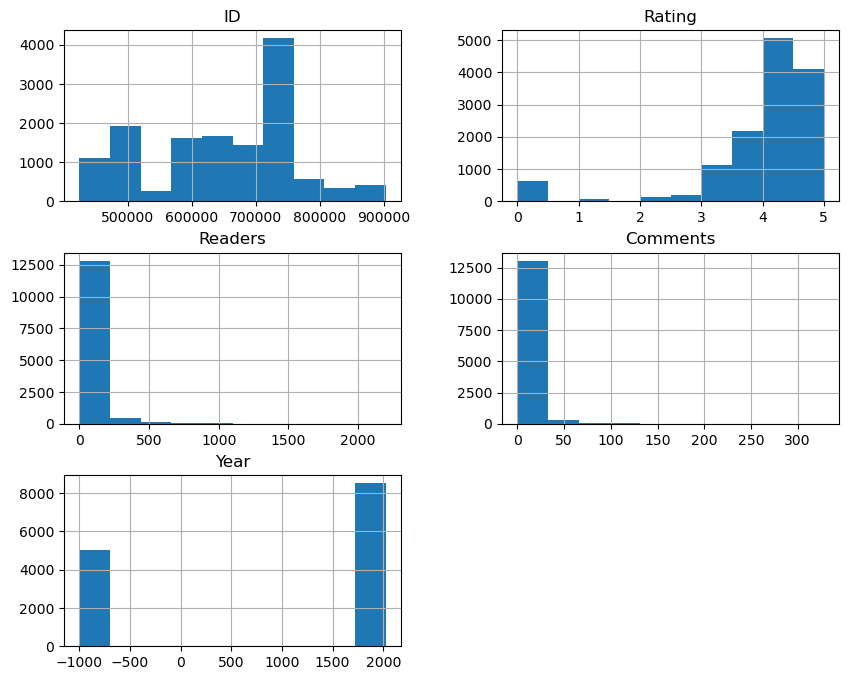

In [ ]:
data.hist(figsize=(10, 8))

### Рейтинг

Абсолютное большинство - 5100 - значений рейтинга имеет значение 4,5.
650 книг имеют так называемый неявный негативный рейтинг, т.е. отсутствия отзыва, просмотра, покупки и т.п., отсутсвтие взаимодействия пользователь-предмет.
Эти нулевые значения можно спрогнозировать.
Значения явного рейтинга распределены в диапазоне оценок от 3-ти до 5-ти.


### Комментарии

Абсолютное большинство - 13000 - значений комментариев имеет значение 0.То есть это неявный негативный рейтинг.
Эти нулевые значения можно спрогнозировать.
Максимальные значения явного рейтинга комментариев равны 7573, 1985 и 807. Далее кривая комментариев резко падает в район 300 комментариев и спускается к 0.

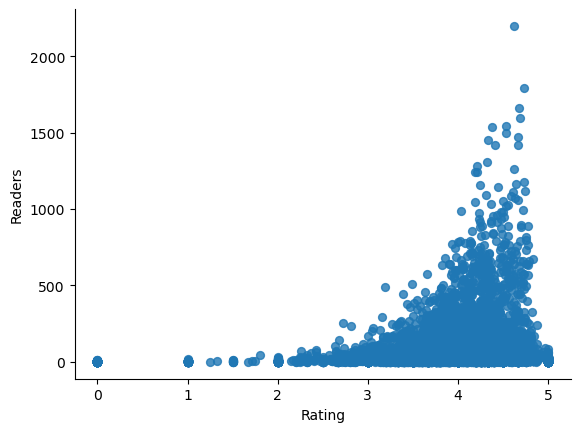

In [ ]:
# Rating vs Readers
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Rating', y='Readers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

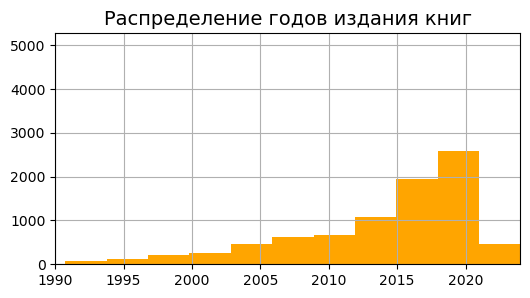

In [ ]:
fig, ax = plt.subplots()
data['Year'].hist(bins=1000, color='orange', figsize=(6,3));
ax.set_xlim((1990,2024));
plt.title(label='Распределение годов издания книг', fontsize=14);